# Whisper V3 Batch Processing Test
Google Colab Pro 

Resources Used:

- vCPU: 4
- Memory: 12
- GPU: 1 Nvidia V100

In [1]:
!pip install --upgrade pip
!pip install --upgrade git+https://github.com/huggingface/transformers.git accelerate datasets[audio]
!pip install torch==2.0.1
!pip install chromadb
!pip install gradio
!pip install langchain
!pip install typing-inspect==0.8.0
!pip install typing_extensions==4.5.0
!pip install tiktoken
!pip install pypdf
!pip install faiss-gpu
!pip install transformers
!pip install InstructorEmbedding
!pip install #sentence_transformers==2.2.2
!pip install accelerate
!pip install bitsandbytes
!pip install xformers
!pip install einops
!pip install pysqlite3-binary
!pip install bitsandbytes
!pip install nltk
!pip install pandas==2.1.1
!pip install git+https://github.com/UKPLab/sentence-transformers.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-z4_tmtrv
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-z4_tmtrv
  Resolved https://github.com/huggingface/transformers.git to commit 0e402e1478ff8c9db876eb7b3a708c1477cec2fa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 26.1 MB/s eta 0:00:00

In [9]:
!pip install flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 20.6 MB/s eta 0:00:00
  Created wheel for flash-attn: filename=flash_attn-2.3.3-cp310-cp310-linux_x86_64.whl size=57042553 sha256=b1df92cb5bd7657d38b789dd48e907aa3e0bd2715c817eb85f3c4320bb11fb3f
  Stored in directory: /root/.cache/pip/wheels/e5/e6/fa/941802ec61d1afd320d27160ab1db98e6dba65381f84b76d4a
Successfully built flash-attn


In [1]:
import torch
from transformers import pipeline
from transformers.pipelines.audio_utils import ffmpeg_read
import warnings
warnings.filterwarnings("ignore")
import os
import textwrap
import langchain
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor
from transformers import LlamaTokenizer, LlamaForCausalLM, pipeline
from InstructorEmbedding import INSTRUCTOR
from huggingface_hub import login
import os
import pandas as pd
from datetime import datetime
import time
print(os.environ['PATH'])



####################
#Setting Up Whisper
####################

MODEL_NAME = "openai/whisper-large-v3"
BATCH_SIZE = 8
FILE_LIMIT_MB = 1000
#TODO:FIX Add functionality to load in CPU if only 1 GPU available
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    MODEL_NAME, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True, use_flash_attention_2=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(MODEL_NAME)

pipe = pipeline(
    task="automatic-speech-recognition",
    model=MODEL_NAME,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    chunk_length_s=30,
    batch_size=BATCH_SIZE,
    torch_dtype=torch_dtype,
    device=device,
)


def transcribe(inputs, task):
    if inputs is None:
        raise gr.Error("No audio file submitted! Please upload or record an audio file before submitting your request.")
    text = pipe(inputs,
                generate_kwargs={"task": task},
                return_timestamps=True)["text"]

    return text

/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin


You are attempting to use Flash Attention 2.0 with a model initialized on CPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
import os
import pandas as pd
from datetime import datetime
from pydub.utils import mediainfo

def get_audio_length(file_path):
    # Get audio file information
    info = mediainfo(file_path)
    # Convert duration from milliseconds to seconds and format it
    minutes, seconds = divmod(float(info['duration']), 60)
    return f"{int(minutes):02d}m {int(seconds):02d}s"


def process_audio_files(audio_folder, text_folder, task):
    log_data = pd.DataFrame(columns=['audio_file', 'text_file', 'audio_length', 'transcription_time(s)'])

    audio_files = [f for f in os.listdir(audio_folder) if os.path.isfile(os.path.join(audio_folder, f))]

    for audio_file in audio_files:
        audio_file_path = os.path.join(audio_folder, audio_file)
        start_time = time.time()
        text = transcribe(audio_file_path, task)
        end_time = time.time() # time.time()

        audio_length = get_audio_length(audio_file_path)
        transcription_time = end_time - start_time

        # minutes, seconds = divmod(transcription_time_seconds, 60)
        # transcription_time = f"{int(minutes):02d}m {int(seconds):02d}s"


        text_filename = os.path.splitext(audio_file)[0] + '.txt'
        text_file_path = os.path.join(text_folder, text_filename)
        with open(text_file_path, 'w', encoding='utf-8') as text_file:
            text_file.write(text)


        log_row = {
            'audio_file': audio_file,
            'text_file': text_filename,
            'audio_length': audio_length,
            'transcription_time(s)': transcription_time
        }
        log_data.loc[len(log_data)] = log_row
        log_data.to_csv('whisper_v3_transcription_log.csv', index=False)

    return log_data


audio_folder = 'audio_data'
text_folder = 'text_data'
task = 'transcribe'

log_data = process_audio_files(audio_folder, text_folder, task)

In [6]:

import pandas as pd

# Load the CSV file into a DataFrame
df_transcription = pd.read_csv('whisper_v3_transcription_log.csv')

# Display the first few rows of the DataFrame to understand its structure
df_transcription.head()

,audio_file,text_file,audio_length,transcription_time(s)
0,09_22_2023.m4a,09_22_2023.txt,113m 15s,249.500155
1,10_20_2023.m4a,10_20_2023.txt,99m 35s,220.082023
2,09_29_2023.m4a,09_29_2023.txt,120m 55s,284.674455
3,10_06_2023.m4a,10_06_2023.txt,114m 24s,269.746635
4,10_12_2023.m4a,10_12_2023.txt,61m 41s,132.888650


from matplotlib import pyplot as plt
_df_0['transcription_time(s)'].plot(kind='hist', bins=20, title='transcription_time(s)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('audio_file').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('text_file').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('audio_length').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['transcription_time(s)'].plot(kind='line', figsize=(8, 4), title='transcription_time(s)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['text_file'].value_counts()
    for x_label, grp in _df_5.groupby('audio_file')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('audio_file')
_ = plt.ylabel('text_file')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['audio_length'].value_counts()
    for x_label, grp in _df_6.groupby('text_file')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('text_file')
_ = plt.ylabel('audio_length')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['audio_file'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='transcription_time(s)', y='audio_file', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['text_file'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='transcription_time(s)', y='text_file', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['audio_length'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='transcription_time(s)', y='audio_length', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

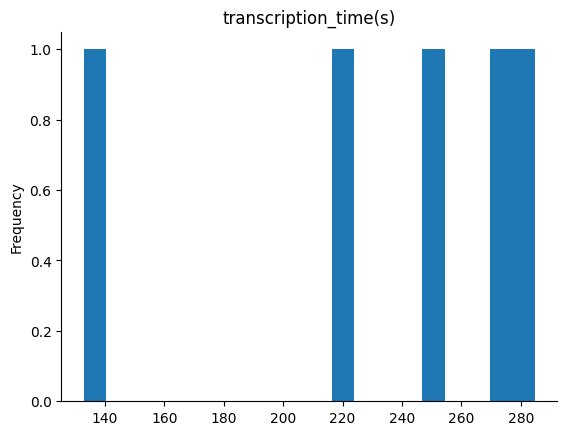

In [7]:
from matplotlib import pyplot as plt
_df_0['transcription_time(s)'].plot(kind='hist', bins=20, title='transcription_time(s)')
plt.gca().spines[['top', 'right',]].set_visible(False)